In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import string

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import io

# figure_dir = None
figure_dir = "../latex/figures"

In [2]:
def loadmat(fname):
    return io.loadmat(fname, simplify_cells=True)

### Find the lock-in amplifier phase offset and field coil imbalance

In [3]:
mat = loadmat("../data/measurement/temperature-sweep/T_sweep_05mA_500Hz_FC_series.mat")

temps = mat["T_axis"]
M = mat["M_x"] + 1j * mat["M_y_vec"]
(ix, ) = np.where((temps >= 9) & (temps <= 9.3))
x = M.real[ix]
y = M.imag[ix]
slope, ofs = np.polyfit(x, y, 1)
angle = np.arctan(slope)
M_inf = (M * np.exp(-1j * angle))[np.where(temps >= 9.4)].mean()
M_corr = M * np.exp(-1j * angle) - M_inf
print(f"angle = {angle:.2e} radians, M_inf = {M_inf:.2f} Phi_0 / A")

angle = -9.76e-03 radians, M_inf = 5.49-0.39j Phi_0 / A


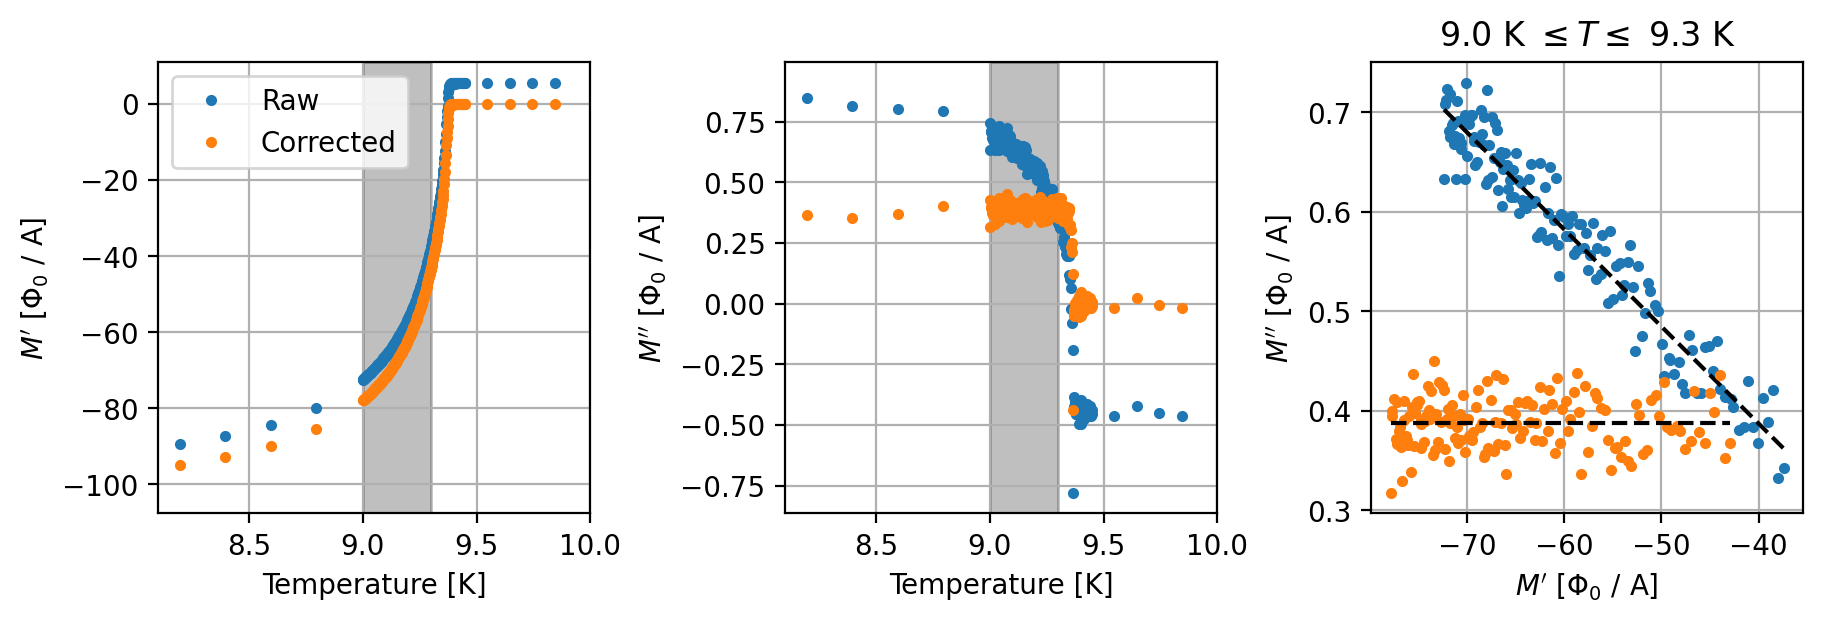

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
axes[0].sharex(axes[1])

axes[0].plot(temps, M.real, "C0.", label="Raw")
axes[0].plot(temps, M_corr.real, "C1.", label="Corrected")
axes[1].plot(temps, M.imag, "C0.")
axes[1].plot(temps, M_corr.imag, "C1.")
axes[2].plot(x, y, "C0.")
axes[2].plot(x, slope * x + ofs, "k--")
axes[2].plot(M_corr.real[ix], M_corr.imag[ix], "C1.")
slope_corr, ofs_corr = np.polyfit(M_corr.real[ix], M_corr.imag[ix], 1)
axes[2].plot(M_corr.real[ix], slope_corr * M_corr.real[ix] + ofs_corr, "k--")

axes[0].legend(loc=2, fontsize=10)
axes[0].set_xlabel("Temperature [K]")
axes[1].set_xlabel("Temperature [K]")
axes[0].set_ylabel("$M'$ [$\\Phi_0$ / A]")
axes[1].set_ylabel("$M''$ [$\\Phi_0$ / A]")
axes[2].set_xlabel("$M'$ [$\\Phi_0$ / A]")
axes[2].set_ylabel("$M''$ [$\\Phi_0$ / A]")
axes[2].set_title("9.0 K $\\leq T\\leq$ 9.3 K")
for ax in axes[:2]:
    ax.axvspan(9, 9.3, color="k", alpha=0.25)
    ax.set_xlim(8.1, 10)
for ax in axes:
    ax.grid(True)

## Figure 2: temperature sweep with zoomed insets

In [5]:
data_dir = "../data/measurement/temperature-sweep"

current_to_mat = {
    0.5: "T_sweep_05mA_500Hz_FC_series.mat",
    2.0: "T_sweep_2mA_500Hz_FC_series.mat",
    3.0: "T_sweep_3mA_500Hz_FC_series.mat",
    4.0: "T_sweep_4mA_500Hz_FC_series.mat",
    5.0: "T_sweep_5mA_500Hz_FC_series.mat",
    6.0: "T_sweep_6mA_500Hz_FC_series_increasing_FC",
    7.0: "T_sweep_7mA_500Hz_FC_series.mat",
    8.0: "T_sweep_8mA_500Hz_FC_series_increasing_FC.mat",
    9.0: "T_sweep_9mA_500Hz_FC_series.mat",
    10.0: "T_sweep_10mA_500Hz_FC_series_increasing_FC.mat",
}

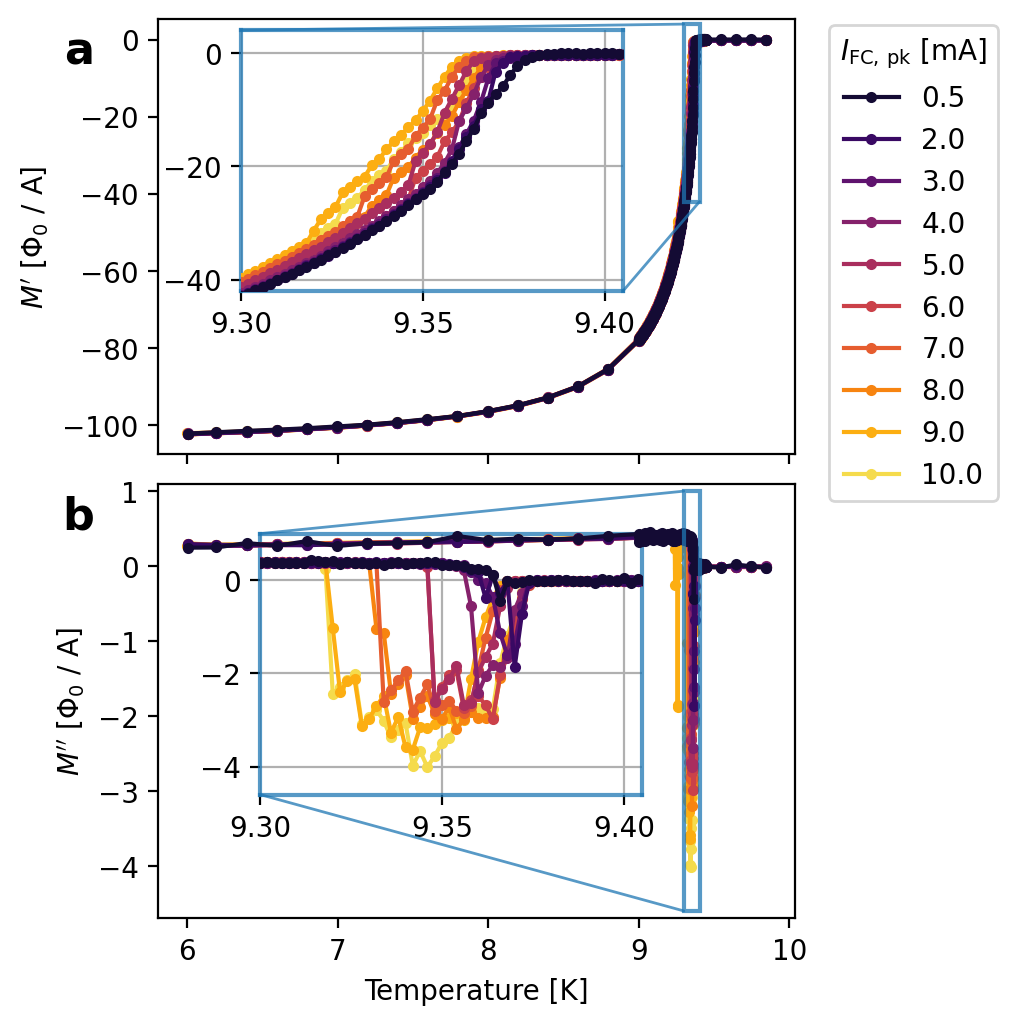

In [6]:
plt.rcParams["font.size"] = 10

fig, axes = plt.subplots(2, 1, figsize=(4, 5), sharex=True, constrained_layout=True)

ax, bx = axes
ax_inset = ax.inset_axes([0.13, 0.375, 0.6, 0.6])
bx_inset = bx.inset_axes([0.16, 0.285, 0.6, 0.6])

colors = plt.get_cmap("inferno")(np.linspace(0, 1, len(current_to_mat) + 2))[1:-1]
for i, (current, fname) in enumerate(current_to_mat.items()):
    mat = loadmat(os.path.join(data_dir, fname))
    temps = mat["T_axis"]
    M = mat["M_x"] + 1j * mat["M_y_vec"]
    M = M * np.exp(-1j * angle) - M_inf
    color = colors[i]
    zorder = 10 + len(current_to_mat) - i
    kwargs = dict(zorder=zorder, color=color)
    ax.plot(temps, M.real, ".-", label=f"{current:.1f}", **kwargs)
    ax_inset.plot(temps, M.real, ".-", label=f"{current:.1f}", **kwargs)
    bx.plot(temps, M.imag, ".-", **kwargs)
    bx_inset.plot(temps, M.imag, ".-", **kwargs)
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    bbox_to_anchor=(1, 1),
    loc="upper left",
    title="$I_{\\mathrm{FC},\\,\\mathrm{pk}}$ [mA]",
    ncols=1,
)

ax.set_ylabel("$M'$ [$\\Phi_0$ / A]")
bx.set_xlabel("Temperature [K]")
bx.set_ylabel("$M''$ [$\\Phi_0$ / A]")

T_range = (9.3, 9.405)
Mp_range = (-42, 4)
Mpp_range = (-4.6, 1)
 
ax_inset.set_xlim(*T_range)
ax_inset.set_ylim(*Mp_range)
bx_inset.set_xlim(*T_range)
bx_inset.set_ylim(*Mpp_range)
bx.set_ylim(-4.7, 1.1)
    
lw = 1.5
color = "C0"
alpha = 0.75
ax.indicate_inset_zoom(ax_inset, edgecolor=color, zorder=100, alpha=alpha, lw=lw)
bx.indicate_inset_zoom(bx_inset, edgecolor=color, zorder=100, alpha=alpha, lw=lw)
for a in [ax_inset, bx_inset]:
    a.grid(True)
    for spine in a.spines.values():
        spine.set_color(color)
        spine.set_linewidth(lw)
        spine.set_alpha(alpha)

for a, label, (x0, y0) in zip(axes.flat, string.ascii_lowercase, [(-0.275, 0.98), (-0.275, 0.98)]):
    a.text(-0.1, 0.975, label, weight="bold", ha="right", va="top", fontsize=16, transform=a.transAxes)

if figure_dir is not None:
    fig.savefig(os.path.join(figure_dir, "susc-vs-temp-insets.pdf"), bbox_inches="tight")

## Figure 2: temperature sweep with zoomed subplots

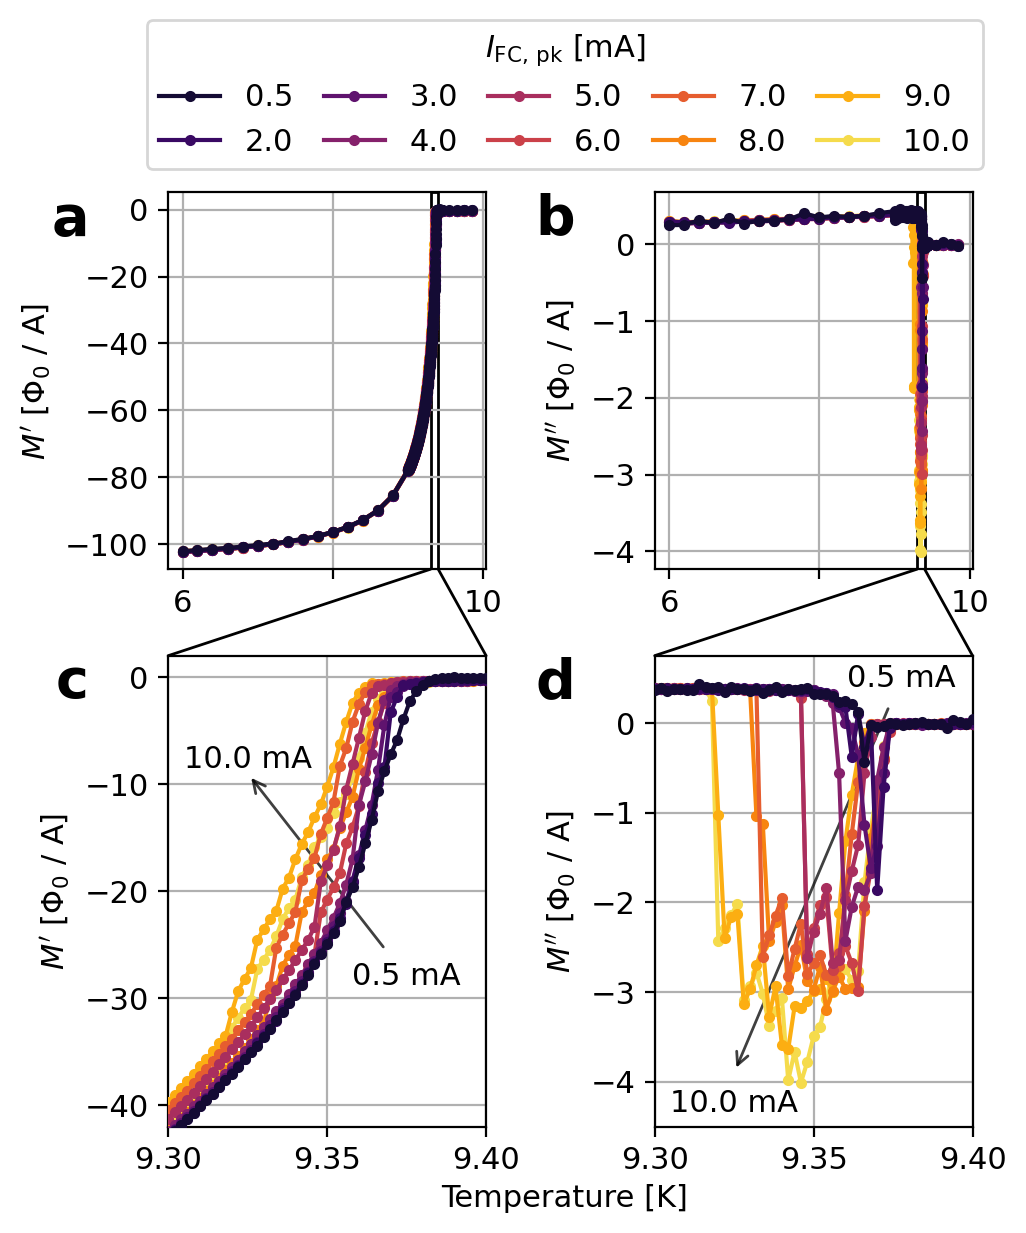

In [7]:
plt.rcParams["font.size"] = 11

fig, axes = plt.subplots(
    2, 2,
    figsize=(5, 5),
    sharex="row",
    constrained_layout=True,
    gridspec_kw=dict(height_ratios=[1, 1.25], hspace=0.075),
)

ax, bx = axes[0]
cx, dx = axes[1]

for i, (current, fname) in enumerate(current_to_mat.items()):
    mat = loadmat(os.path.join(data_dir, fname))
    temps = mat["T_axis"]
    M = mat["M_x"] + 1j * mat["M_y_vec"]
    M = M * np.exp(-1j * angle) - M_inf
    color = colors[i]
    zorder = 10 + len(current_to_mat) - i
    kwargs = dict(zorder=zorder, color=color)
    ax.plot(temps, M.real, ".-", label=f"{current:.1f}", **kwargs)
    cx.plot(temps, M.real, ".-", label=f"{current:.1f}", **kwargs)
    bx.plot(temps, M.imag, ".-", **kwargs)
    dx.plot(temps, M.imag, ".-", **kwargs)
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.55, 1),
    loc="lower center",
    title="$I_{\\mathrm{FC},\\,\\mathrm{pk}}$ [mA]",
    ncols=len(handles)//2,
    columnspacing=1,
)
ax.set_ylabel("$M'$ [$\\Phi_0$ / A]")
cx.set_ylabel("$M'$ [$\\Phi_0$ / A]")
bx.set_ylabel("$M''$ [$\\Phi_0$ / A]")
dx.set_ylabel("$M''$ [$\\Phi_0$ / A]")


T_range = (9.3, 9.4)
Mp_range = (-42, 2)
Mpp_range = (-4.5, 0.75)

fig.text(0.55, 0, "Temperature [K]", ha="center", va="top")
    
cx.set_xlim(*T_range)
cx.set_ylim(*Mp_range)
dx.set_xlim(*T_range)
dx.set_ylim(*Mpp_range)
ax.set_xticks([6, 8, 10])
ax.set_xticklabels(["6", "", "10"])

for a in axes[0]:
    a.axvspan(*T_range, edgecolor="k", facecolor="none", alpha=1)
    
for ax1, ax2 in ((ax, cx), (bx, dx)):
    y0 = ax1.get_ylim()[0]
    y1 = ax2.get_ylim()[1]
    T0, T1 = T_range
    con1 = mpl.patches.ConnectionPatch(
        (T0, y0), (T0, y1), "data", axesA=ax1, axesB=ax2,
    )
    con2 = mpl.patches.ConnectionPatch(
        (T1, y0), (T1, y1), "data", axesA=ax1, axesB=ax2, connectionstyle="arc",
    )
    fig.add_artist(con1)
    fig.add_artist(con2)
    
    
currents = list(current_to_mat)
axes[1, 0].annotate(
    f"{currents[0]:.1f} mA",
    (9.325, -9),
    xytext=(9.375, -28),
    fontsize=11,
    ha="center",
    va="center",
    backgroundcolor="none",
    arrowprops=dict(arrowstyle="->", facecolor="k", lw=1, alpha=0.75),
)
axes[1, 0].text(
    *(9.325, -9),
    f"{currents[-1]:.1f} mA",
    size=11,
    ha="center",
    va="bottom",
    backgroundcolor="none",
)
axes[1, 1].annotate(
    f"{currents[0]:.1f} mA",
    (9.325, -3.9),
    xytext=(9.3775, 0.5),
    fontsize=11,
    ha="center",
    va="center",
    backgroundcolor="none",
    arrowprops=dict(arrowstyle="->", facecolor="k", lw=1, alpha=0.75),
)
axes[1, 1].text(
    *(9.325, -4.4),
    f"{currents[-1]:.1f} mA",
    size=11,
    ha="center",
    va="bottom",
    backgroundcolor="none",
)

# pos = [(-0.275, 0.98), (-0.275, 0.98), (-0.125, 0.98), (-0.175, 0.98)]
for a, label in zip(axes.flat, string.ascii_lowercase):
    a.text(-0.25, 1, label, weight="bold", ha="right", va="top", fontsize=20, transform=a.transAxes)
    a.grid(True)
    
if figure_dir is not None:
    fig.savefig(os.path.join(figure_dir, "susc-vs-temp-1col.pdf"), bbox_inches="tight")

## Figure 3: $I_\mathrm{FC}$ sweep

In [8]:
path = "../data/measurement/fc-current-sweep"

In [9]:
def get_temp(s):
    return float(s.split(".")[0].split("_")[1].replace("p", "."))

In [10]:
sorted(os.listdir(path), key=get_temp)

['FCsweep_9p29.mat',
 'FCsweep_9p3.mat',
 'FCsweep_9p31.mat',
 'FCsweep_9p32.mat',
 'FCsweep_9p33.mat',
 'FCsweep_9p34.mat',
 'FCsweep_9p35.mat',
 'FCsweep_9p36.mat',
 'FCsweep_9p37.mat']

In [11]:
fc_sweep = {}
for p in sorted(os.listdir(path), key=get_temp):
    fc_sweep[get_temp(p)] = loadmat(os.path.join(path, p))

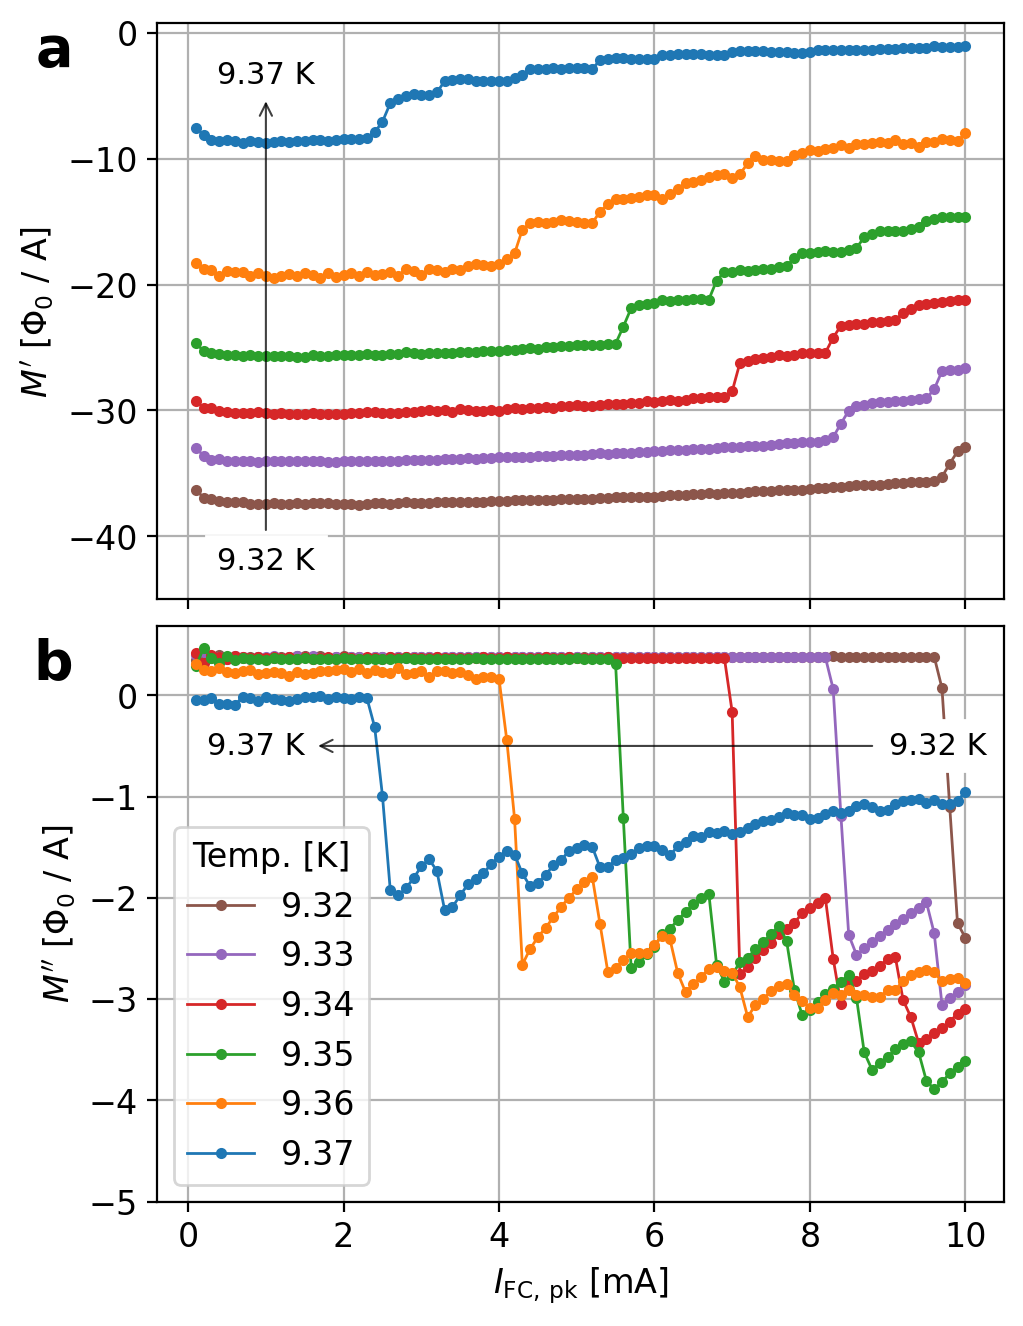

In [12]:
plt.rcParams["font.size"] = 12

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5, 6.5), constrained_layout=True)

temps = []

for i, (temp, mat) in enumerate(fc_sweep.items()):
    if temp < 9.32:
        # There is no significant nonlinearity below 9.32 K,
        # so we don't plot those curves.
        continue
    temps.append(temp)
    I_fc = mat["FC_amp"]
    Mx = mat["M_x"]
    My = mat["M_y_vec"]
    M = Mx + 1j * My
    M = M * np.exp(-1j * angle) - M_inf
    color = f"C{len(fc_sweep) - i - 1}"
    axes[0].plot(I_fc, M.real, ".-", lw=1, label=f"{temp:.2f}", color=color)
    axes[1].plot(I_fc, M.imag, ".-", lw=1, label=f"{temp:.2f}", color=color)
    
axes[1].legend(loc="lower left", title="Temp. [K]", fontsize=12)
axes[1].set_xlabel("$I_{{\\mathrm{{FC}},\\,\\mathrm{pk}}}$ [mA]")
axes[0].set_ylabel("$M'$ [$\\Phi_0$ / A]")
axes[1].set_ylabel("$M''$ [$\\Phi_0$ / A]")

axes[0].set_ylim(-45, axes[0].get_ylim()[1])
axes[0].annotate(
    f"{temps[0]:.2f} K",
    (1, -5),
    xytext=(1, -42),
    fontsize=11,
    ha="center",
    va="center",
    backgroundcolor="white",
    arrowprops=dict(arrowstyle="->", facecolor="k", lw=0.75, alpha=0.75),
)
axes[0].text(
    *(1, -4.5),
    f"{temps[-1]:.2f} K",
    size=11,
    ha="center",
    va="bottom",
    backgroundcolor="white",
)

axes[1].set_ylim(-5, axes[1].get_ylim()[1])
axes[1].annotate(
    f"{temps[0]:.2f} K",
    (1.6, -0.5),
    xytext=(9.65, -0.5),
    fontsize=11,
    ha="center",
    va="center",
    backgroundcolor="white",
    arrowprops=dict(arrowstyle="->", facecolor="k", lw=0.75, alpha=0.75),
)
axes[1].text(
    *(1.5, -0.5),
    f"{temps[-1]:.2f} K",
    size=11,
    ha="right",
    va="center",
    backgroundcolor="white",
)

for a, label, (x0, y0) in zip(axes.flat, string.ascii_lowercase, [(-0.1, 1), (-0.1, 0.98)]):
    a.grid(True)
    a.text(x0, y0, label, weight="bold", ha="right", va="top", fontsize=20, transform=a.transAxes)
    
if figure_dir is not None:
    fig.savefig(os.path.join(figure_dir, "M-vs_I_fc.pdf"), bbox_inches="tight")